<img src="files/roof.jpg" alt="Picture" width="600">

## Energy Harvesting: Thermoelectric Shingle

Jim, Rachel, Liam

### Introduction

- Brainstorming opportunities for harvesting
- Project selection
- Prototyping & data collection
- Mathematical model
- Economic output


### Brainstorming

The most common type of energy loss is thermal or heat energy loss

Some ideas we came up with:

- Solar panels on window blinds
- Thermoelectric Generators (TEGs) under road
- TEGs under roof

#### Comparison

|<h2>Aspect</h2>|<h2>Solar Window Blinds</h2>|<h2>Road TEGs</h2>|<h2>Roof TEGs</h2>|
|------|-------------------|---------|---------|
|<p>**Operation time**</p>|<p>Very limited</p>|<p>Daytime</p>|<p>Daytime</p>|
|<p>**Setting**</p>|<p>Domestic</p>|<p>City/Public</p>|<p>Domestic</p>|
|<p>**Who gets energy?**</p>|<p>Individual</p>|<p>Public/Power grid</p>|<p>Individual</p>|

### Mathematical Model
The rate of change in heat energy = [rate of added energy] - [rate of energy loss]

$\frac{dQ}{dt} = S(t) - P(t) - C(t)$

_S(t)_ is the sun's rate of inputting energy, _P(t)_ is the power output of the TEG over time, and _C(t)_ is the rate at which heat is lost to conduction in the air.

#### Solar Irradiance

The sun's input energy rate depends on the irradiance

>_Irradiance_ - power per unit area from sun's light; depends on season, location, weather, and time of day

$S(t) = eAI(t)$

<i>e</i> is the absorption, ranging from 0-1, <i>A</i> is the surface area, and <i>I(t)</i> is the irradiance over time. Direct lighting averages 1000 W/m<sup>2</sup>.

<img src="files/insolation.gif" alt="Irradiance curve" width="600px">

A sample solar irradiance curve over the course of a day (Source: __[ResearchGate](http://www.mpoweruk.com/solar_power.htm)__)

#### TEG Energy Conversion

$P(t) = IV = V^{2}/R = V(\Delta T)^{2}/R$

_V(&Delta;T)_ is the voltage output of the TEG, given from the manufacturer, and <i>R</i> is the internal resistance of the TEG

We know that $T = Q/mc$, so $\Delta T = [\frac{Q(t)}{mc} + T_o] - T(t)$

_Q(t)_ is the shingle's heat energy, <i>m</i> is the mass of the shingle, <i>c</i> is the specific heat capacity, and _T(t)_ is the ambient temperature

#### Conduction

The air will absorb some of the heat from the shingle (ever seen the shimmering air off a roof or road?).

Heat transfer equation: $Q = kA\Delta Tt/L$

<i>k</i> is the thermal conductivity of the air (0.0262 W/(m &deg;C) for Nitrogen), <i>A</i> is the area of the surface, <i>&Delta;T</i> is the temperature difference between the materials, and <i>L</i> is the length along where the heat is being transferred.

Therefore, $C(t) = \frac{dQ}{dt} = kA\Delta T/L$

Like before, <i>&Delta;T</i> is the excess heat energy compared to the air.

$\Delta T = (\frac{Q(t)}{mc} + T_o) - T(t)$

<i>T<sub>o</sub></i> is the initial temperature

All together

$\frac{dQ}{dt} = AeI(t) - \frac{V(\Delta T)^{2}}{R}- \frac{kA\Delta T}{L}$,

$\Delta T= (\frac{Q(t)}{mc} + T_o) - T(t)$

Model at e=0.80


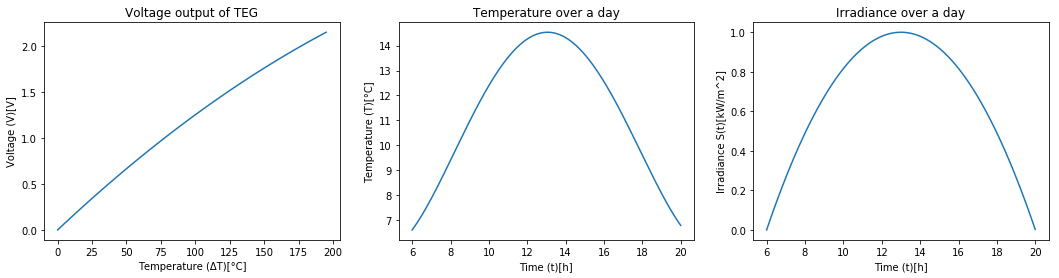

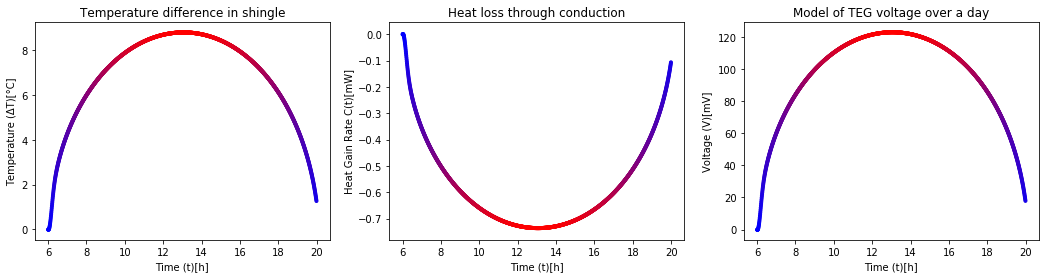

In [45]:
#%matplotlib inline

import datetime

#For web stuff
import json
import requests

#Data science stuff
import numpy as np
import matplotlib.pyplot as plt

#Jupyter UI stuff
from IPython.display import display, clear_output
from ipykernel.pylab.backend_inline import flush_figures

import ipywidgets as widgets
from ipywidgets import Output

#Solar/environmental properties
coeffI = np.polyfit(np.array([6, 13, 20]), [0, 1000, 0], 2) #see above diagram
I = lambda t: max(np.polyval(coeffI, t), 0) #W/m^2
weatherDay = None

#Shingle properties
A = 0.004**2 #m^2
e = 0.8
R = 1.25 #Ohms
m = 2322 * A * 0.0047625 #kg
c = 920 #J/kg C
coeffV = np.polyfit([0, 50, 80, 100, 120, 150, 170, 180], [0, 0.6, 1.0, 1.3, 1.4, 1.8, 1.9, 2.0], 2)
coeffV[2] = 0
V = lambda dT: np.polyval(coeffV, dT) #V

#Air properties
k = 0.0262 #W/m deg C; thermal conductivity of Nitrogen
coeffT = np.polyfit(np.array([3, 6, 9, 14, 17, 20, 23]), np.array([45, 45, 50, 60, 50, 45, 45]), 4)
T = lambda t: (max(np.polyval(coeffT, t), 0) - 32) / 1.8 #deg C
L = 0.005 #m, volume of air being heated

# #UI Stuff
# out = Output()
# eControl = widgets.FloatSlider(min=0.1, max=1, value=0.8, description="Absorption:")
# useDate = widgets.Checkbox(value=False, description="Use weather data:")
# dateControl = widgets.DatePicker(description="Pick a date:", disabled=True)
# dateValid = widgets.Valid(description="Date within 1 month?", disabled=True)
# city = widgets.Text(description="US City:", disabled=True)
# runButton = widgets.Button(description="Run model")
# plots = Output()

def generateData(time):
    stepsize = time[1] - time[0]
    Q_total = 0
    
    data = np.zeros((len(time), 5))
    
    progress = widgets.FloatProgress(min=0, max=1.0, value=0, description="Generating data:")
    display(progress)
    
    for i in range(len(time)):
        s = A*e*I(time[i]) #S(t)
        dT = Q_total / (m * c) + T(time[0]) - T(time[i])
        v = V(dT)
        con = (k * A * dT / L)
        
        dQdt = s - con - v**2 / R
        
        data[i,:] = [v, Q_total, con, dT, time[i]]
        
        #print("S(t): %f\tP(t): %f\tC(t): %f" % (A*e*I(time[i]), -(V(Q_total / (m * c))**2 / R), -(k * A * Q_total / (m * c) / L)))
        
        Q_total += dQdt * (3600 * stepsize)
        
        progress.value += 1 / len(time)
        progress.description = "Making data (%.1f%%):" % (progress.value * 100)
        
    progress.close()
    del progress
    
    return data

def blend(vec1, vec2, x):
    if len(vec1) != len(vec2):
        raise Exception("Vector lengths must match")

    result = []
    for i in range(len(vec1)):
        result.append(
            ((vec2[i] - vec1[i]) * x + vec1[i])
        )
    return result

def displayGraphs(button):
    global e
    global I
    global T
    
#     e = eControl.value
    
#     if weatherDay != None and useDate.value:
#         r = requests.get("http://history.openweathermap.org/data/2.5/history/city?q={},USA&type=hour&start={}&cnt=24"
#                         .format(city.value, (weatherDay - datetime(1970,1,1)).total_seconds()))
        
    
#     with out:
#         clear_output()
    print("Model at e=%.2f" % e)
#     clear_output()

    data = generateData(np.arange(6, 20, 0.01))

    times = data[:,4]
    voltages = data[:,0]
    heats = data[:,1]
    conduction = data[:,2]
    temperature_difference = data[:,3]
    colors = [blend([0,0,1], [1,0,0], (Q - min(heats)) / (max(heats) - min(heats))) for Q in heats]

    progress = widgets.FloatProgress(min=0, max=1.0, value=0, description="Plotting (1/6):")
    display(progress)

    fig = plt.figure(0, figsize=(18,4))

    plt.subplot(1,3,1)
    plt.plot(np.arange(0, 200, 5), [V(x) for x in np.arange(0, 200, 5)])
    plt.title("Voltage output of TEG")
    plt.xlabel("Temperature (ΔT)[°C]")
    plt.ylabel("Voltage (V)[V]")

    progress.value += 1/6
    progress.description = "Plotting (2/6):"

    plt.subplot(1,3,2)
    plt.plot(times, [T(t) for t in times])
    plt.title("Temperature over a day")
    plt.xlabel("Time (t)[h]")
    plt.ylabel("Temperature (T)[°C]")

    progress.value += 1/6
    progress.description = "Plotting (3/6):"

    plt.subplot(1,3,3)
    plt.plot(times, [I(t)/1000 for t in times])
    plt.title("Irradiance over a day")
    plt.xlabel("Time (t)[h]")
    plt.ylabel("Irradiance S(t)[kW/m^2]")

    progress.value += 1/6
    progress.description = "Plotting (4/6):"

    plt.figure(figsize=(18,4))

    plt.subplot(1, 3, 1)
    plt.scatter(times, temperature_difference, c=colors, marker=".")
    plt.title("Temperature difference in shingle")
    plt.xlabel("Time (t)[h]")
    plt.ylabel("Temperature (ΔT)[°C]")

    progress.value += 1/6
    progress.description = "Plotting (5/6):"

    plt.subplot(1,3,2)
    plt.scatter(times, -1000 * np.array(conduction), c=colors, marker=".")
    plt.title("Heat loss through conduction")
    plt.xlabel("Time (t)[h]")
    plt.ylabel("Heat Gain Rate C(t)[mW]")

    progress.value += 1/6
    progress.description = "Plotting (6/6):"

    plt.subplot(1,3,3)
    plt.scatter(times, 1000 * voltages, c=colors, marker=".")
    plt.title("Model of TEG voltage over a day")
    plt.xlabel("Time (t)[h]")
    plt.ylabel("Voltage (V)[mV]")

    plt.show()

    progress.close()
    del progress

def dataModelCompare():
    global I
    coeffI = np.polyfit(np.array([6, 13, 20]), [0, 1000, 0], 2) #see above diagram
    I = lambda t: max(np.polyval(coeffI, t), 0)
    
    times = []
    voltages = []

    times2 = []
    voltages2 = []

    with open("eh_data_latest.csv", "r") as f:
        for line in f.readlines():
            data = line.split(",")
            if float(data[1]) > 0.2:
                continue
            times.append(float(data[0]))
            voltages.append(float(data[1]) * 1000)
            if float(data[0]) < 15.33:
                times2.append(float(data[0]))
                times2.append(float(data[0]) + 2*(15.33 - float(data[0])))
                voltages2.append(float(data[1]) * 1000)
                voltages2.append(float(data[1]) * 1000)

    #Polyfitting
    p = np.polyfit(times2, voltages2, 2)
    py = []
    px = np.arange(min(times2), max(times2))
    for t in px:
        py.append(np.polyval(p, t))

    peq = "V = %.2ft^2 + %.2ft + %.2f" % (p[0], p[1], p[2]) #polynomial equation

    normal = plt.figure(figsize=(13.5,4.5))

    colors = []
    for i in range(len(voltages)):
        colors.append(np.array(blend([0,0,255.0], [255.0,0,0], (voltages[i] - min(voltages)) / (max(voltages) - min(voltages)))) / 255)

    plt.figure(normal.number)
    plt.subplot(1,2,1)
    plt.scatter(times, voltages, c=colors, marker='.')
    plt.xlabel("Time [h]")
    plt.ylabel("Voltage [mV]")
    plt.title("Peltier device voltage over 1 day")

    colors = []
    for i in range(len(voltages2)):
        colors.append(np.array(blend([0,0,255.0], [255.0,0,0], (voltages2[i] - min(voltages2)) / (max(voltages2) - min(voltages2)))) / 255)

    plt.subplot(1,2,2)
    plt.scatter(times2, voltages2, c=colors, marker='.') #plotting symmetric data
    plt.plot(px, py, "-k") #plotting line of best fit
    plt.xlabel("Time (t) [h]")
    plt.ylabel("Voltage (V) [mV]")
    plt.title("Peltier device voltage over 1 day (Symmetrized)")
    plt.text(12, 10, peq)
    plt.show()
    
    del voltages, times, voltages2, times2, colors
    
    data = generateData(np.arange(6, 20, 0.01))

    times = data[:,4]
    voltages = data[:,0]
    heats = data[:,1]
    colors = [blend([0,0,1], [1,0,0], (Q - min(heats)) / (max(heats) - min(heats))) for Q in heats]
    
    model = plt.figure(figsize=(13.5,4.5))
    plt.subplot(1,2,2)
    plt.scatter(times, 1000 * voltages, c=colors, marker=".")
    plt.title("Model of TEG voltage over a day")
    plt.xlabel("Time (t)[h]")
    plt.ylabel("Voltage (V)[mV]")
    
    I = lambda t: max(np.polyval(coeffI, t), 0) if t < 15.33 else np.polyval(coeffI, 15.33) * np.exp(-(t-15.33)/0.5)
    
    data = generateData(np.arange(6, 20, 0.01))

    times = data[:,4]
    voltages = data[:,0]
    heats = data[:,1]
    colors = [blend([0,0,1], [1,0,0], (Q - min(heats)) / (max(heats) - min(heats))) for Q in heats]
    
    plt.subplot(1,2,1)
    plt.scatter(times, 1000 * voltages, c=colors, marker=".")
    plt.title("Model of TEG voltage over a day (Shaded)")
    plt.xlabel("Time (t)[h]")
    plt.ylabel("Voltage (V)[mV]")
    plt.show();
    
'''
def dateValidator(checkbox):
    if checkbox:
        dateControl.disabled = False
        dateValid.disabled = False
        city.disabled = False
    else:
        dateControl.disabled = True
        dateValid.disabled = True
        city.disabled = True
        
def parseDate(date):
    if date != None:
        dateNow = datetime.datetime.today()
        
        difference = dateNow - date
        if difference.days > 30 or dateNow < date : #API won't work
            weatherDay = None
            dateValid.value = False
        else:
            weatherDay = date
            dateValid.value = True
        
display(out)
with out:
    display(eControl)
    display(useDate)
    display(dateControl)
    display(dateValid)
    display(city)
    widgets.interactive(dateValidator, checkbox=useDate)
    widgets.interactive(parseDate, date=dateControl)
    display(runButton)
    runButton.on_click(displayGraphs)
''';

displayGraphs(None)

### Prototyping
<img src="files/Prototype.jpg" alt="prototype in testing" width="900">

#### Materials
<div class="container">
    <div class="row">
        <div class="col-sm-6">
            <img src="files/teg.jpg" alt="TEG" width="400"/>
        </div>
        <div class="col-sm-6">
            <img src="files/trinketm0.jpg" width="400"/>
        </div>
    </div>
</div>
- Thermoelectric generator
- Shingle
- Trinket M0 (Arduino-like)
- Laptop

#### Physical conditions
<img src="files/weather.gif" width="1000">
- 30&deg; incline
- Near-constant sunlight
 - Shaded around 3:20pm
- Temperature 50-60&deg;F
- Faced west

#### Data logging algorithm
<div class="container">
    <div class="row">
        <div class="col-md-6">
            <br />
            <ul>
                <li>Read analog voltage from Trinket M0</li>
                <li>Send voltage over USB to laptop</li>
                <li>Write voltage to file</li>
                <li>9am-6pm</li>
            </ul>
        </div>
        <div class="col-md-6">
            <img src="files/drawing.jpg" width="500">
        </div>
    </div>
</div>

>##### Arduino (CircuitPython)
>The Arduino (actually Adafruit Trinket M0) initialized pin 2 as an analog pin. Then every 100th of a minute, it read the voltage applied to pin 2 (from the TEG). This voltage was then sent over the USB connection to the PC running Ubuntu Linux. Next, the Arduino displayed a color on its RGB led between Blue and Red (0-0.5V, respectively) using linear interpolation.

>##### PC (Python)
>The PC (Ubuntu Linux) waited until 9am to start logging (local time, EDT). Then it waited for messages over USB from the Arduino and logged the voltage to a Comma-Separated Values (.csv) file. Finally, it stopped checking for messages at 6pm.

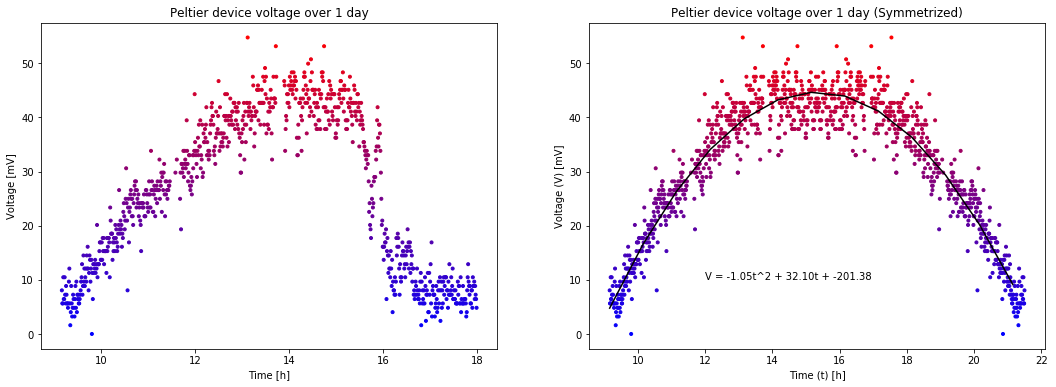

In [62]:
%matplotlib inline

#Jim Furches

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, HTML

def blend(vec1, vec2, x):
    if len(vec1) != len(vec2):
        raise Exception("Vector lengths must match")

    result = []
    for i in range(len(vec1)):
        result.append(
            ((vec2[i] - vec1[i]) * x + vec1[i])
        )
    return result

times = []
voltages = []

times2 = []
voltages2 = []

with open("eh_data_latest.csv", "r") as f:
    for line in f.readlines():
        data = line.split(",")
        if float(data[1]) > 0.2:
            continue
        times.append(float(data[0]))
        voltages.append(float(data[1]) * 1000)
        if float(data[0]) < 15.33:
            times2.append(float(data[0]))
            times2.append(float(data[0]) + 2*(15.33 - float(data[0])))
            voltages2.append(float(data[1]) * 1000)
            voltages2.append(float(data[1]) * 1000)

#Polyfitting
p = np.polyfit(times2, voltages2, 2)
py = []
px = np.arange(min(times2), max(times2))
for t in px:
    py.append(np.polyval(p, t))

peq = "V = %.2ft^2 + %.2ft + %.2f" % (p[0], p[1], p[2]) #polynomial equation
    
normal = plt.figure(figsize=(18,6))

colors = []
for i in range(len(voltages)):
    colors.append(np.array(blend([0,0,255.0], [255.0,0,0], (voltages[i] - min(voltages)) / (max(voltages) - min(voltages)))) / 255)

display(HTML("<h3>Data</h3>"))
    
plt.figure(normal.number)
plt.subplot(1,2,1)
plt.scatter(times, voltages, c=colors, marker='.')
plt.xlabel("Time [h]")
plt.ylabel("Voltage [mV]")
plt.title("Peltier device voltage over 1 day")

colors = []
for i in range(len(voltages2)):
    colors.append(np.array(blend([0,0,255.0], [255.0,0,0], (voltages2[i] - min(voltages2)) / (max(voltages2) - min(voltages2)))) / 255)

plt.subplot(1,2,2)
plt.scatter(times2, voltages2, c=colors, marker='.') #plotting symmetric data
plt.plot(px, py, "-k") #plotting line of best fit
plt.xlabel("Time (t) [h]")
plt.ylabel("Voltage (V) [mV]")
plt.title("Peltier device voltage over 1 day (Symmetrized)")
plt.text(12, 10, peq);

With shading..
Model at e=0.80


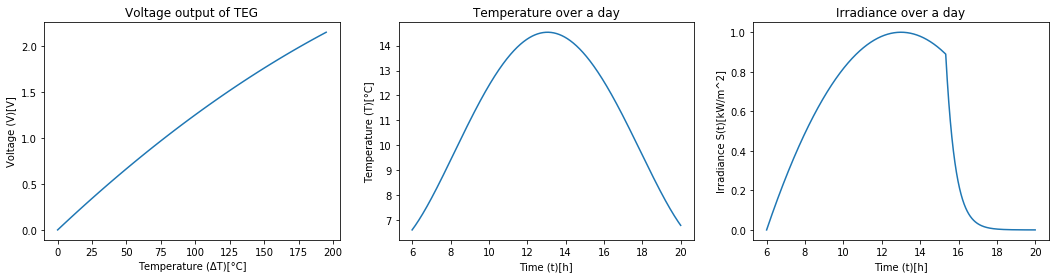

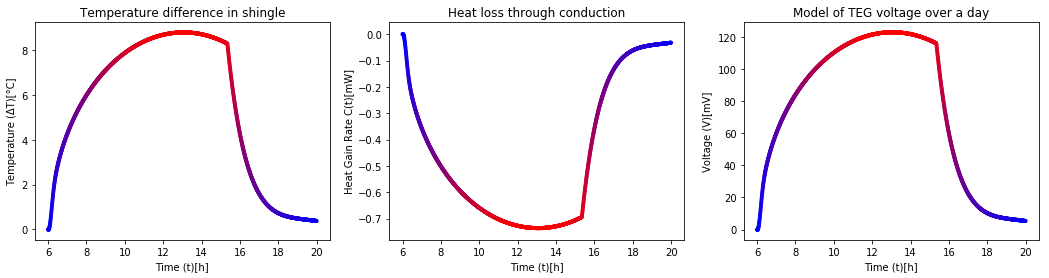

In [47]:
print("With shading..")
I = lambda t: max(np.polyval(coeffI, t), 0) if t < 15.33 else np.polyval(coeffI, 15.33) * np.exp(-(t-15.33)/0.5)
displayGraphs(None)

### Results
The raw data in Figure 1 show that energy harvesting output does increase with the sun's height in the sky. The shingle became shaded by tree cover at around 3:20pm, yielding the sharp decay curve. The symmetrized data in Figure 2 give an idea of a unit's output provided there are no obstructions. A power output would follow the sun's height in the sky, reaching maximum at the sun's zenith.

Google reports that a typical roof size is 1500 sq ft. The peltier module itself was 4 x 4 cm, so that roof could host up to 84375 Peltier devices. Wired in series, this would provide a near-constant 4218.75 V during peak operation period, an equivalent of 2812.5 D-cell batteries.

_Raw data from testing. The sharp decay curve is from the shingle being shaded by tree cover._

_Symmetrized data. The data were reflected about t=15.33 (3:20 pm) to provide a clearer picture of what one could expect given optimal conditions (no shade, little cloud cover). Quadratic regression yielded a mathematical model of the output of one unit:_ $V = -1.05t^{2} + 32.10t - 201.38$ (mV)_, where `t` is a function of the time in hours, so 3:20pm is 15.33._

### Code for other devices
Included for completeness are the Python files of this project.

In [ ]:
#Jim Furches

#This is the PC logging code

import serial
import time

#linux-specific device on my computer
serialDevice = "/dev/serial/by-id/usb-Adafruit_Industries_Trinket_M0-if00"

#start at 09:00, end at 18:00
startTime = 9
endTime = 18 #timestamp after which to stop logging data

while True:
    try:
        #setup serial port
        arduino = serial.Serial(serialDevice, timeout=1)

        print("Waiting for start time...")
        while time.localtime().tm_hour < startTime:
            time.sleep(30)

        print("Starting")

        startTime = time.localtime() #now

        #open our logfile and begin collecting data
        #data_tmz-yyyymmdd-hhmmss.csv
        with open("data_%s-%d%d%d-%d%d%d.csv" % (startTime.tm_zone, startTime.tm_year, startTime.tm_mon, startTime.tm_mday, startTime.tm_hour, startTime.tm_min, startTime.tm_sec), "w+") as f:
            while True:
                #get data from serial connection and make it pretty - count,voltage
                data = str(arduino.readline())[2:-5]
                if len(data) == 0:
                    continue
                print(data)

                #get voltage measurement in V
                voltage = float(data.split(',')[1])

                #get current time
                now = time.localtime()
                timestamp = now.tm_hour + now.tm_min / 60 + now.tm_sec / 3600

                #should we end?
                if timestamp > endTime:
                    break

                #Log data
                f.write("%f,%f\n" % (timestamp, voltage))
            
            #Save our precious data
            f.close()
            break
    except serial.SerialException:
        input("Port connection faulty. Check connection and press ENTER...")


In [ ]:
#Jim Furches

#This is the Arduino (CircuitPython) code

import time
import board
import digitalio
import analogio
import adafruit_dotstar as dotstar

def blend(vec1, vec2, x):
    if len(vec1) != len(vec2):
        raise Exception("Vector lengths must match")

    result = []
    for i in range(len(vec1)):
        result.append(
            int((vec2[i] - vec1[i]) * x + vec1[i])
        )
    return result

def getVoltage(pin):
    return pin.value * 3.3 / 65536

pin = analogio.AnalogIn(board.A2)
dot = dotstar.DotStar(board.APA102_SCK, board.APA102_MOSI, 1, brightness=0.2)
led = digitalio.DigitalInOut(board.D13)

led.direction = digitalio.Direction.OUTPUT

readingsPerHour = 100

led.value = True
while getVoltage(pin) > 0.5: #some absurd amount
    pass

led.value = False

count = 0

while True:
    voltage = getVoltage(pin)
    
    print("%d,%f" % (count, voltage))

    count += 1

    dot[0] = blend([0, 0, 255], [255, 0, 0], voltage / 0.5)

    time.sleep(60 / readingsPerHour * 60)